In [1]:
# Include some libraries
from prelims import DGPrelims
from odetools import RK4Solver
import numpy as np

In this workbook, we run linear, constant-coefficient advection with a DG scheme, and we analyze convergence.

In [2]:
def solve_ode(N, M, NT, T, a, u0):
    # Solve the ODE with DG
    # Given:
    #   N: So that N - 1 is the degree of subelements
    #   M: Number of subelements
    #   NT: So that NT + 2 is the number of time elements
    #   T: Final time
    #   a: The coefficient in the ODE
    #   u0: The initial condition
    # Returns:
    #   prelims: The preliminaries for the DG scheme
    #   The solution at the final time

    # ODE Stuff first:

    # Create the ODE solver
    solver = RK4Solver(NT, (0, T))

    # Now DG stuff:
    # Create the preliminaries
    prelims = DGPrelims(N, M, is_periodic=True)

    # Create the right hand side of the PDE
    def f(u):
        return a * u
    
    # Create the right hand side of the DG scheme
    RHS = lambda u, t: prelims.RHS(f, u)

    # Define initial condition
    initial_u = u0(prelims.x)

    # Plug the DG data into the ODE solver, and return solution
    return prelims, solver.solve(RHS, initial_u, pause_every=20)

Now, we create a way to run the function just to get the error against the true solution:

In [24]:
def evaluate_dg(N, M, NT, T, a, u0):
    # Evaluate the solution at the final time
    # Given:
    #   N: So that N - 1 is the degree of subelements
    #   M: Number of subelements
    #   NT: So that NT + 2 is the number of time elements
    #   T: Final time
    #   a: The coefficient in the ODE
    #   u0: The initial condition
    # Returns:
    #   The solution at the final time

    # Solve the ODE
    prelims, solution_generator = solve_ode(N, M, NT, T, a, u0)

    # Return the solution at the final time
    expected, tf = list(solution_generator)[-1]

    # Construct the true solution at time tf
    actual = [u0(x - a * tf) for x in prelims.x]

    # Return the L∞ error
    return prelims.integrate((expected - actual) ** 2)

First, lets take a look at what the solution looks like, if the initial condition is a bell function:

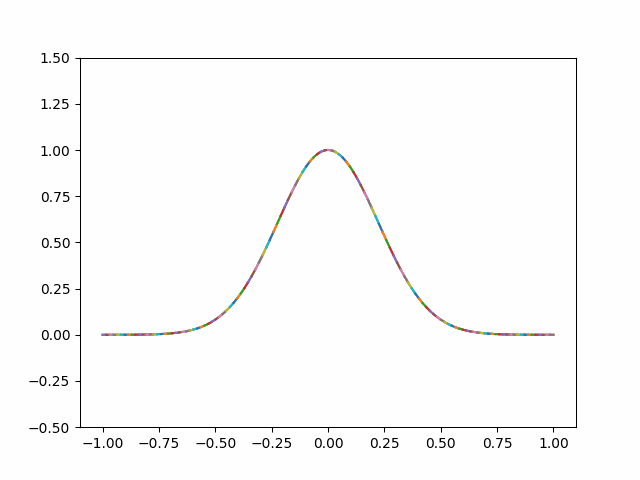

In [25]:
# Initial condition and ODE parameters
u0 = lambda x: np.exp(-10 * ((x + 1) % 2 - 1) ** 2) # The (x + 1) % 2 - 1 is used to force periodicity over [-1, 1]
a = 1

# Some example DG parameters
N_example = 4
M_example = 124

# Some time parameters
NT_example = 1000
T_example = 1

from animate import animate
import matplotlib.pyplot as plt

@animate
def animation():
    prelims, generator = solve_ode(N_example, M_example, NT_example, T_example, a, u0)
    for u, t in generator:
        # Plot a frame
        plt.figure()
        plt.plot(prelims.x, u, label='DG Solution')
        plt.plot(prelims.x, u0(prelims.x - a * t), label='True Solution')
        plt.ylim(-.5, 1.5)

        yield

animation()

Let's see what the error is from these computations:

In [26]:
print("The error was", evaluate_dg(N_example, M_example, NT_example, T_example, a, u0))

The error was 6.862464189015652e-14


Let's see if we can estimate the order of this error, as we change our space or time discretization:

In [27]:
evaluate_given_time = lambda N: evaluate_dg(N_example, M_example, N, T_example, a, u0)

from evaluation_tools import unproper_order_func, proper_order_func

unproper_order_func(lambda N: T_example / (N + 1), evaluate_given_time, [500, 600, 700, 800, 900, 1000, 1100], 2, verbose=True)

Our errors were [6.95181313e-14 6.90212494e-14 6.88103356e-14 6.87088044e-14
 6.86551360e-14 6.86246419e-14 6.86062898e-14]
and [6.86246419e-14 6.85947151e-14 6.85819822e-14 6.85758380e-14
 6.85725831e-14 6.85707301e-14 6.85696130e-14]


4.055246634458173

We achieve approximately $O(\Delta t^4)$ convergence: this corresponds to the theoretical order for RK4. Let's try to get our space convergence:

In [28]:
T_example = .01

evaluate_given_space = lambda M: evaluate_dg(4, M, 100, T_example, a, u0)

proper_order_func(lambda M: 2 / (M + 1), evaluate_given_space, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], verbose=True)

[1.         0.66666667 0.5        0.4        0.33333333 0.28571429
 0.25       0.22222222 0.2        0.18181818]
[1.91035602e-04 1.65124241e-04 5.54268663e-05 6.00840309e-06
 4.94875346e-06 1.16138840e-07 6.77541729e-07 1.32014294e-07
 1.02306130e-07 4.80039403e-08]
Our errors were [1.91035602e-04 1.65124241e-04 5.54268663e-05 6.00840309e-06
 4.94875346e-06 1.16138840e-07 6.77541729e-07 1.32014294e-07
 1.02306130e-07 4.80039403e-08]


5.495925183753489

FIXME is that an issue?

Let's see what happens when we change N, the number of mesh points in each sub interval. Lets try an N of 5:

In [30]:
evaluate_given_space = lambda M: evaluate_dg(5, M, 1000, T_example, a, u0)

proper_order_func(lambda M: 2 / (M + 1), evaluate_given_space, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], verbose=True)

[1.         0.66666667 0.5        0.4        0.33333333 0.28571429
 0.25       0.22222222 0.2        0.18181818]
[3.81529095e-04 3.07857107e-05 1.67175800e-06 5.70114204e-07
 5.67885044e-08 6.29624237e-08 1.86497887e-09 5.52858179e-09
 1.20737348e-09 6.94391436e-10]
Our errors were [3.81529095e-04 3.07857107e-05 1.67175800e-06 5.70114204e-07
 5.67885044e-08 6.29624237e-08 1.86497887e-09 5.52858179e-09
 1.20737348e-09 6.94391436e-10]


7.986302386061765